# Reinforcement Learning: An Introduction 2nd Edition
***

# Chapter 2  -- Multi-armed Bandits

**There are two kinds of feedback: ** 
* **Evaluative feedback** indicates how good the action taken was, but not whether it was the best or the worst action possible, which is the basis of reinforcement learning.
* **Instructive feedback** indicates the correct action to take, independently of the action actually taken, which is the basis of supervised learning.

## 1. A k-armed Bandit Problem
You are faced repeatedly with a choice among k different options, or actions. After each choice you receive a numerical reward chosen from a stationary probability distribution that depends on the action you selected. Your objective is to maximize the expected total reward over some time period, for example, over 1000 action selections, or time steps. This is the k-armed bandit problem.
![](https://s3-ap-south-1.amazonaws.com/av-blog-media/wp-content/uploads/2018/09/im_210.png)
**Notation:**  
$k$ : # set of actions  
$A_t$ : **action** selected on time step $t$  
$R_t$ : **reward** corresponding to $A_t$  
$q_*(a)$ : **value** of an arbitrary action $a$, and $q_*(a) = \mathbb{E}[R_t | A_t=a]$  
$Q_t(a)$ : the **estimated value** of action $a$ at time step $t$, We would like $Q_t(a)$ to be close to $q_*(a)$  

**There are two ways to select a action on time step $t$:**
* **Exploiting:** Selecting from *greedy* actions whose estimated value is greatest. 
* **Exploring:** Selecting from *nongreedy* actions whose estimated value is nearly as good but with substantial uncertainty.

In any specific case, whether it is better to explore or exploit depends in a complex way on the precise *values of the estimates*, *uncertainties*, and the *number of remaining steps*.

## 2. Action-value Methods
Methods for estimating the values of actions and for using the estimates to make action selection decisions, which we collectively call *action-value methods*.  
* ** *sample-average* method ** for estimating action values:  
$$
Q_t(a) = \frac{\text{sum of rewards when a taken prior to t}}{\text{number of times a taken prior to t}} = \frac{\sum_{i=1}^{t-1}R_i\cdot\mathbb{1}_{A_i=1}}{\sum_{i=1}^{t-1}\mathbb{1}_{A_i=1}}
$$
where $\mathbb{1}_{predicate}$ denotes the random variable that is 1 if *predicate* is true and 0 if it is not.  
$Q_t(a)$ will converge to $q_∗(a)$ as the denominator goes to infinity, by the law of large numbers. 
* ** *greedy* action selection method** use the estimated value to select an action: 
$$
A_t = \underset{a}{argmax}Q_t(a)
$$
** $\epsilon-greedy$ methods ** as an alternative, to behave greedily most of the time, but every once in a while, with small probability $\epsilon$, instead select randomly among all the actions with equal probability.

## 3. The 10-armed Testbed
[Offical Release Python Code](https://github.com/ShangtongZhang/reinforcement-learning-an-introduction/blob/master/chapter01/tic_tac_toe.py)  

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [2]:
class Bandit:
    # @k_arm: # of arms
    # @epsilon: probability for exploration in epsilon-greedy algorithm
    # @initial: initial estimation for each action
    # @step_size: constant step size for updating estimations
    # @sample_averages: if True, use sample averages to update estimations instead of constant step size
    # @UCB_param: if not None, use UCB algorithm to select action
    # @gradient: if True, use gradient based bandit algorithm
    # @gradient_baseline: if True, use average reward as baseline for gradient based bandit algorithm
    def __init__(self, k_arm=10, epsilon=0., initial=0., step_size=0.1, sample_averages=False, UCB_param=None,
                 gradient=False, gradient_baseline=False, true_reward=0.):
        self.k = k_arm
        self.step_size = step_size
        self.sample_averages = sample_averages
        self.indices = np.arange(self.k)
        self.time = 0
        self.UCB_param = UCB_param
        self.gradient = gradient
        self.gradient_baseline = gradient_baseline
        self.average_reward = 0
        self.true_reward = true_reward
        self.epsilon = epsilon
        self.initial = initial

    def reset(self):
        # real reward for each action
        self.q_true = np.random.randn(self.k) + self.true_reward

        # estimation for each action
        self.q_estimation = np.zeros(self.k) + self.initial

        # # of chosen times for each action
        self.action_count = np.zeros(self.k)

        self.best_action = np.argmax(self.q_true) 

    # get an action for this bandit
    def act(self):
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.indices)

        if self.UCB_param is not None:
            UCB_estimation = self.q_estimation + \
                     self.UCB_param * np.sqrt(np.log(self.time + 1) / (self.action_count + 1e-5))
            q_best = np.max(UCB_estimation)
            return np.random.choice([action for action, q in enumerate(UCB_estimation) if q == q_best])

        if self.gradient:
            exp_est = np.exp(self.q_estimation)
            self.action_prob = exp_est / np.sum(exp_est)
            return np.random.choice(self.indices, p=self.action_prob)

        q_best = np.max(self.q_estimation)
        return np.random.choice([action for action, q in enumerate(self.q_estimation) if q == q_best])

    # take an action, update estimation for this action
    def step(self, action):
        # generate the reward under N(real reward, 1)
        reward = np.random.randn() + self.q_true[action]
        self.time += 1
        self.average_reward = (self.time - 1.0) / self.time * self.average_reward + reward / self.time
        self.action_count[action] += 1

        if self.sample_averages:
            # update estimation using sample averages
            self.q_estimation[action] += 1.0 / self.action_count[action] * (reward - self.q_estimation[action])
        elif self.gradient:
            one_hot = np.zeros(self.k)
            one_hot[action] = 1
            if self.gradient_baseline:
                baseline = self.average_reward
            else:
                baseline = 0
            self.q_estimation = self.q_estimation + self.step_size * (reward - baseline) * (one_hot - self.action_prob)
        else:
            # update estimation with constant step size
            self.q_estimation[action] += self.step_size * (reward - self.q_estimation[action])
        return reward

def simulate(runs, time, bandits):
    best_action_counts = np.zeros((len(bandits), runs, time))
    rewards = np.zeros(best_action_counts.shape)
    for i, bandit in enumerate(bandits):
        for r in tqdm(range(runs)):
            bandit.reset()
            for t in range(time):
                action = bandit.act()
                reward = bandit.step(action)
                rewards[i, r, t] = reward
                if action == bandit.best_action:
                    best_action_counts[i, r, t] = 1
    best_action_counts = best_action_counts.mean(axis=1)
    rewards = rewards.mean(axis=1)
    return best_action_counts, rewards

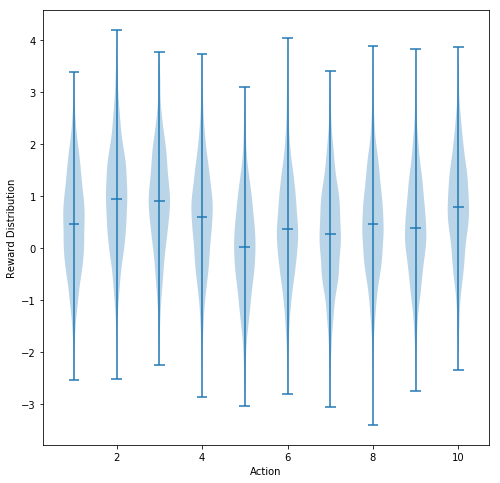

In [3]:
# This was a set of 2000 randomly generated k-armed bandit problems with k = 10, For each bandit problem, 
# the action values, q_∗(a), a = 1, . . . , 10, were selected according to a normal (Gaussian) distribution 
# with mean 0 and variance 1.
# Figure 2.1
plt.figure(figsize=(8, 8))
plt.violinplot(dataset=np.random.randn(2000, 10) + np.random.rand(10), showmeans=True)
plt.xlabel('Action')
plt.ylabel('Reward Distribution')
plt.show()

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:56<00:00, 35.58it/s]


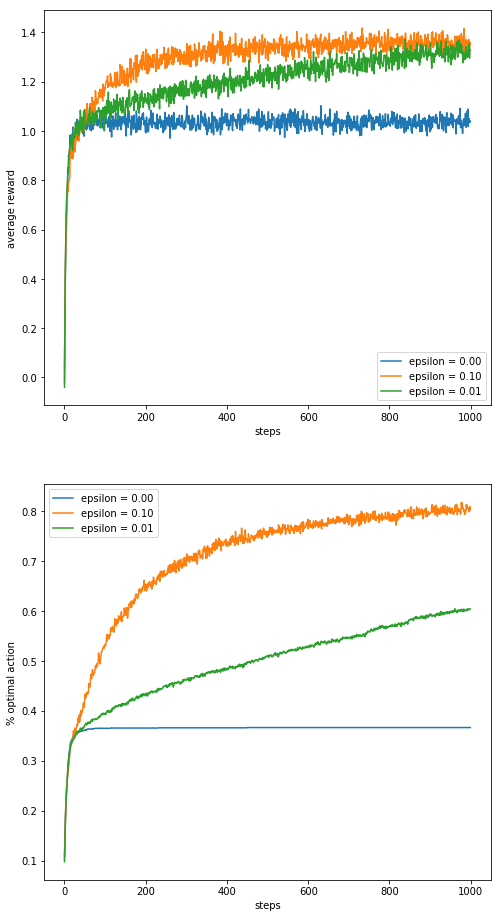

In [4]:
# Comparison between greedy-method and e-greedy-method with different epsilon.
epsilons = [0, 0.1, 0.01]
bandits = [Bandit(epsilon=eps, sample_averages=True) for eps in epsilons]
best_action_counts, rewards = simulate(runs=2000, time=1000, bandits=bandits)
plt.figure(figsize=(8, 16))

plt.subplot(2, 1, 1)
for eps, rewards in zip(epsilons, rewards):
    plt.plot(rewards, label='epsilon = %.02f' % (eps))
plt.xlabel('steps')
plt.ylabel('average reward')
plt.legend()

plt.subplot(2, 1, 2)
for eps, counts in zip(epsilons, best_action_counts):
    plt.plot(counts, label='epsilon = %.02f' % (eps))
plt.xlabel('steps')
plt.ylabel('% optimal action')
plt.legend()
plt.show()

## 4. Incremental Implementation
* **Incremental Implemention of *sample-average* method**  
The expression $[Target−OldEstimate]$ is an *error* in the estimate.It is reduced by taking a step toward the "Target." The target is presumed to indicate a desirable direction in which to move, though it may be noisy.
$$
NewEstimate \leftarrow OldEstimate + StepSize [Target - OldEstimate] \\
Q_{n+1} = Q_n + \frac{1}{n}[R_n - Q_n] \\
$$

* **A simple bandit algorithm**  
$\text{Initialize, for }a = 1 \text{ to } k:$   
$Q(a) \leftarrow 0 $  
$N(a) \leftarrow 0 $  
$\text{Loop forever}:$   
$$A=\left\{
    \begin{array}{ll}
      argmax_a Q(a) \text{..........with probability  } 1-\epsilon \text{  (breaking ties randomly)}\\
      \text{a random action  .....with probability   } \epsilon
    \end{array}
  \right.
$$
$R \leftarrow bandit(A)$  
$N(A) \leftarrow N(A) + 1$  
$Q(A) \leftarrow Q(A) + 1$


## 5. Tracking a Nonstationary Problem
The **averaging methods** are appropriate for **stationary bandit problems**, that is, for bandit problems in which the reward probabilities do not change over time. As noted earlier, we often encounter reinforcement learning problems that are effectively **nonstationary**. In such cases it makes sense to **give more weight to recent rewards than to long-past rewards.** One of the most popular ways of doing this is to use a constant step-size parameter $\alpha$.
* Example: **Exponential Recency-Weighted Average**
$$
Q_{n+1} = Q_n + \alpha [R_n - Q_n] = (1 - \alpha)^n Q_1 + \sum\limits_{i=1}^n\alpha{(1 - \alpha)}^{n-i}R_i
$$
And sum of the weights: $(1 - \alpha)^n + \sum\limits_{i=1}^n\alpha{(1 - \alpha)}^{n-i} = 1$, and step-size parameter $\alpha \in (0, 1]$ is constant.
* **Stochastic approximation theory**  
The conditions required to assure convergence with probability 1: 
$$\sum\limits_{n=1}^\infty \alpha_n(a) = \infty \text{  and  } \sum\limits_{n=1}^\infty \alpha_n^2(a) < \infty $$
The first condition is required to guarantee that the steps are large enough to eventually overcome any initial conditions or random fluctuations. The second condition guarantees that eventually the steps become small enough to assure convergence.  
**In addition,** sequences of step-size parameters that meet the conditions often converge very slowly or need considerable tuning in order to obtain a satisfactory convergence rate.

## 6.Optimistic Initial Values
* The downside is that the initial estimates become, in effect, a set of parameters that must be picked by the user, if only to set them all to zero. 
* The upside is that they provide an easy way to supply some <u>prior knowledge</u> about what level of rewards can be expected. Initial action values can also be used as a simple way to <u>encourage exploration</u>.

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:52<00:00, 38.08it/s]


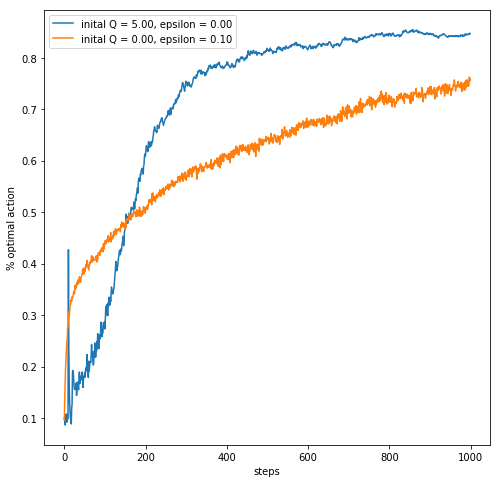

In [5]:
# Comparison between greedy-method with initial estimation and e-greedy-method.
epsilons = [0, 0.1]
initials = [5, 0]
bandits = [Bandit(epsilon=eps, initial=init, step_size=0.1) for eps, init in zip(epsilons, initials)]
best_action_counts, _ = simulate(runs=2000, time=1000, bandits=bandits)

plt.figure(figsize=(8, 8))

for init, eps, counts in zip(initials, epsilons, best_action_counts):
    plt.plot(counts, label='inital Q = %.02f, epsilon = %.02f' % (init, eps))
plt.xlabel('steps')
plt.ylabel('% optimal action')
plt.legend()
plt.show()

## 7. Upper-Confidence-Bound Action Selection
$\epsilon-greedy$ action selection forces the non-greedy actions to be tried, but indiscriminately, with no preference for those that are nearly greedy or particularly uncertain. It would be better to select among the non-greedy actions according to their potential for actually being optimal, taking into account both how close their estimates are to being maximal and the uncertainties in those estimates.   
$$ 
A_t = \underset{a}{argmax}\big[Q_t(a) + c\sqrt{\frac{\ln t}{N_t(a)}}\big]
$$
**Notation:**  
* $\ln t$ : the natural logarithm of $t$
* $N_t(a)$ : # action $a$ has been selected prior to time $t$
* $\sqrt{\frac{\ln t}{N_t(a)}}$ : a measure of the uncertainty or variance in the estimate of $a$'s value.
* $c$ : determining the confidence level

**Note:**   
If action $a$ is selected, $N_t(a) \nearrow $ , then uncertainty $\searrow$  
If not, $t \nearrow$, then $\ln t \nearrow$, uncertainty $\nearrow$.   
$N_t(a)$ improves faster than $\ln t$ ; $UCB$ is not practical. 

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:53<00:00, 37.59it/s]


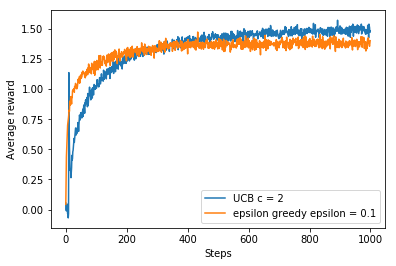

In [7]:
bandits = []
bandits.append(Bandit(epsilon=0, UCB_param=2, sample_averages=True))
bandits.append(Bandit(epsilon=0.1, sample_averages=True))
_, average_rewards = simulate(runs=2000, time=1000, bandits=bandits)

plt.plot(average_rewards[0], label='UCB c = 2')
plt.plot(average_rewards[1], label='epsilon greedy epsilon = 0.1')
plt.xlabel('Steps')
plt.ylabel('Average reward')
plt.legend()
plt.show()

## 8. Gradient Bandit Algorithm
Learning a numerical ***preference*** for each action $a$, which we denote $H_t(a)$. The larger the preference, the more often that action is taken, but the preference has no interpretation in terms of reward. **Only the relative preference of one action over another is important.**
* ***Soft-max Distribution***
$$
Pr\{A_t=a\} = \frac{e^{H_t(a)}}{\sum_{b=1}^{k}e^{H_t(b)}} = \pi_t(a)
$$
$\pi_t(a)$ for the probability of taking action $a$ at time $t$;   
Initially all action preferences are the same(e.g.: $H_t(a)=0$)
* ***Stochastic Gradient Ascent***  
On each step, after selecting action $A_t$ and receiving the reward $R_t$:  
$$
H_{t+1}(A_t) = H_t(A_t) + \alpha(R_t − \bar{R_t})(1 − \pi_t(A_t)) \text{, and }
$$ 
$$
H_{t+1}(a) = H_t(a) − \alpha(R_t − \bar{R_t}) \pi_t{(a)} \text{, for all }a \neq A_t
$$
**Where:**  
$\alpha > 0$ is a step-size parameter  
$\bar{R_t} \in \mathbb{R} $ is the average of all the rewards up through and including time t, serveing as a baseline with which the reward is compared.

***The Bandit Gradient Algorithm as Stochastic Gradient Ascent***  
* ***gradient ascent***  
$H_t(a)$ would be updated by:
$$ 
H_{t+1}(a) = H_t(a) + \alpha \frac{\partial \mathbb{E}[R_t]}{\partial H_t(a)}
$$
where the measure of performance here is the expected reward:
$$
\mathbb{E}[R_t] = \sum\limits_{x} \pi_t(x)q_*(x)
$$
Now, we will prove that the updates in the former algorithm are equal to in expect value.  
$$
\begin{split}
\frac{\partial \mathbb{E}[R_t]}{\partial H_t(a)}  & = \frac{\partial}{\partial H_t(a)}\big[ \sum\limits_{x} \pi_t(x)q_*(x)\big]  \\
& = \sum\limits_{x} q_*(x) \frac{\partial\pi_t(x)}{\partial H_t(a)} \\
& = \sum\limits_{x} (q_*(x) - B_t) \frac{\partial\pi_t(x)}{\partial H_t(a)}
\end{split}
$$
**$B_t$**, called the baseline, can be any scalar that does not depend on $x$.   
It won't change the equation because $\sum_x\frac{\partial\pi_t(x)}{\partial H_t(a)} = 0$--as $H_t(a)$ is changed, some actions' probabilities go up and some go down, but the sum of the changes must be zero because the sum of the probabilities is always one.  
**Next:**  
$$
\begin{split}
\frac{\partial \mathbb{E}[R_t]}{\partial H_t(a)} & = \sum\limits_{x} \pi_t(x)(q_*(x) - B_t) \frac{\partial\pi_t(x)}{\partial H_t(a)} \big/ \pi_t(x)  \\
& = \mathbb{E}\big[(q_*(x) - B_t) \frac{\partial\pi_t(x)}{\partial H_t(a)} \big/ \pi_t(x)\big] \\
& = \mathbb{E}\big[(R_t - \bar{R_t}) \frac{\partial\pi_t(x)}{\partial H_t(a)} \big/ \pi_t(x)\big] \\
& = \mathbb{E}\big[(R_t - \bar{R_t})\pi_t(A_t)(\mathbb{1}_{a=x} - \pi_t(a))\big/ \pi_t(x)\big] \\
& = \mathbb{E}\big[(R_t - \bar{R_t})(\mathbb{1}_{a=x} - \pi_t(a))\big]
\end{split}
$$
we have chosen the baseline $B_t = \bar{R_t}$ and substituted $R_t$ for $q_∗(A_t)$, which is permitted because $E[R_t|A_t] = q_∗(A_t)$. And $\frac{\partial\pi_t(x)}{\partial H_t(a)} = \pi_t(x)(\mathbb{1}_{a=x} - \pi_t(a))$.  
**Now we have: as a instance of stochastic gradient ascent**  
$$
H_{t+1}(a) = H_t(a) + \alpha (R_t - \bar{R_t})(\mathbb{1}_{a=x} - \pi_t(a))  \text{  ......for all a}
$$

* **Derivative of *soft-max* equation**  
Use $$ \frac{\partial}{\partial{x}}\big[ \frac{f(x)}{g(x)}\big] = \frac{\frac{\partial f(x)}{\partial{x}}g(x) - f(x)\frac{\partial g(x)}{\partial{x}}}{g(x)^2}$$

* **Note about the choice of the baseline:**  
The choice of the baseline does not affect the expected update of the algorithm, but it does affect the variance of the update and thus the rate of convergence.

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:52<00:00, 18.61it/s]


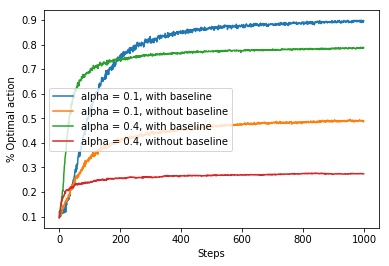

In [9]:
bandits = []
bandits.append(Bandit(gradient=True, step_size=0.1, gradient_baseline=True, true_reward=4))
bandits.append(Bandit(gradient=True, step_size=0.1, gradient_baseline=False, true_reward=4))
bandits.append(Bandit(gradient=True, step_size=0.4, gradient_baseline=True, true_reward=4))
bandits.append(Bandit(gradient=True, step_size=0.4, gradient_baseline=False, true_reward=4))
best_action_counts, _ = simulate(runs=2000, time=1000, bandits=bandits)
labels = ['alpha = 0.1, with baseline',
          'alpha = 0.1, without baseline',
          'alpha = 0.4, with baseline',
          'alpha = 0.4, without baseline']

for i in range(0, len(bandits)):
    plt.plot(best_action_counts[i], label=labels[i])
plt.xlabel('Steps')
plt.ylabel('% Optimal action')
plt.legend()
plt.show()

## 9. Associative Search(Contextual Bandits)
***Associative search***, so called because it involves both *trial-and-error learning* to search for the best actions, and *association* of these actions with the situations in which they are best. Associative search tasks are often now called ***contextual bandits*** in the literature.   
***Associative search tasks*** are intermediate between the ***k-armed bandit problem*** and the ***full reinforcement learning problem***. They are like the full reinforcement learning problem in that they involve learning a policy, but like our version of the k-armed bandit problem in that each action affects only the immediate reward. If actions are allowed to affect the **next situation as well as the reward**, then we have the full reinforcement learning problem.  
***To be continue ...***

## 10. Summary
***Several simple ways of balancing exploration and exploitation***
* $\epsilon-greedy\_method$
* $UCB\_method$
* $Gradient\_bandit\_algorithms$
* $Initializing\_estimates\_optimistically$  

***Parameter Study***

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:56<00:00, 34.91it/s]


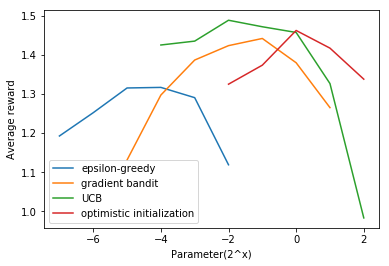

In [10]:
labels = ['epsilon-greedy', 'gradient bandit', 'UCB', 'optimistic initialization']
generators = [lambda epsilon: Bandit(epsilon=epsilon, sample_averages=True),
              lambda alpha: Bandit(gradient=True, step_size=alpha, gradient_baseline=True),
              lambda coef: Bandit(epsilon=0, UCB_param=coef, sample_averages=True),
              lambda initial: Bandit(epsilon=0, initial=initial, step_size=0.1)]
parameters = [np.arange(-7, -1, dtype=np.float),
              np.arange(-5, 2, dtype=np.float),
              np.arange(-4, 3, dtype=np.float),
              np.arange(-2, 3, dtype=np.float)]

bandits = []
for generator, parameter in zip(generators, parameters):
    for param in parameter:
        bandits.append(generator(pow(2, param)))

_, average_rewards = simulate(runs=2000, time=1000, bandits=bandits)
rewards = np.mean(average_rewards, axis=1)

i = 0
for label, parameter in zip(labels, parameters):
    l = len(parameter)
    plt.plot(parameter, rewards[i:i+l], label=label)
    i += l
plt.xlabel('Parameter(2^x)')
plt.ylabel('Average reward')
plt.legend()
plt.show()

***Other methods of balancing exploration and exploitation***  
* $Gittins\_indices$
* $Bayesian\_methods$($posterior\_sampling$ or $Thompson\_sampling$)
* $Approximate\_reinforcement\_learning\_methods$

***